# Class Activation Map
### Reference
1. [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150)
2. [Original github](https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import callbacks

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def resblock(X, filter, args, stage, block):
  x = layers.BatchNormalization()(X)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=filter,
                    kernel_size=(3, 3),
                    strides=(1, 1) if stage == 0 or block > 0 else (2 ,2),
                    padding='same',
                    kernel_initializer=args.init,
                    kernel_regularizer=args.reg)(x)

  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=filter,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding='same',
                    kernel_initializer=args.init,
                    kernel_regularizer=args.reg)(x)

  if stage == 0 or block > 0:
    out = layers.Add()([x, X])
    return out
  else:
    id = layers.Conv2D(filters=filter,
                      kernel_size=(1, 1),
                      strides=(2, 2),
                      padding='same',
                      kernel_initializer=args.init,
                      kernel_regularizer=args.reg)(X)
    out = layers.Add()([x, id])
    return out
  

In [3]:
def build_graph(X, args):
  # network stem
  x = layers.Conv2D(filters=16,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding='same',
                    kernel_initializer=args.init,
                    kernel_regularizer=args.reg)(X)

  for stage_idx, filter in enumerate(args.filters):
    for block in range(args.n_block):
      x = resblock(x, filter, args, stage_idx, block)
      print(f'{stage_idx+2}-{block+1} size {x.shape}')
  
  # network head
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(units=10,
                   kernel_initializer=args.init,
                   kernel_regularizer=args.reg)(x)
  x = layers.Softmax()(x)
  return x

In [4]:
def build_model(args):
  inputs = layers.Input(shape=args.input_shape)
  outputs = build_graph(inputs, args)
  model = models.Model(inputs=inputs, outputs=outputs)
  return model

In [5]:
class Config:
  lr = 1e-1
  epochs = 65
  batch_size = 128
  momentum = 0.9
  weight_decay = 1e-4
  decay_step = 1
  filters = [16, 32, 64]
  input_shape = (32, 32, 3)
  n_block = 3
  loss = losses.SparseCategoricalCrossentropy(from_logits=False)
  metrics = metrics.SparseCategoricalAccuracy()
  init = initializers.HeNormal()
  reg = regularizers.L2(l2=weight_decay)
  opt = optimizers.SGD(learning_rate=lr, momentum=momentum)

In [6]:
model = build_model(Config)

2-1 size (None, 32, 32, 16)
2-2 size (None, 32, 32, 16)
2-3 size (None, 32, 32, 16)
3-1 size (None, 16, 16, 32)
3-2 size (None, 16, 16, 32)
3-3 size (None, 16, 16, 32)
4-1 size (None, 8, 8, 64)
4-2 size (None, 8, 8, 64)
4-3 size (None, 8, 8, 64)


In [13]:
model.load_weights('resnet20.h5')

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [14]:
model.compile(optimizer=Config.opt,
              loss=Config.loss,
              metrics=Config.metrics)

In [10]:
x_test = tf.divide(tf.cast(x_test, tf.float32), 255.)
x_test = (x_test - tf.math.reduce_mean(x_test)) / tf.math.reduce_std(x_test)

In [15]:
model.evaluate(x=x_test, y=y_test)

313/313 [==============================] - 38s 120ms/step - loss: 0.8254 - sparse_categorical_accuracy: 0.8501


[0.8253878951072693, 0.8501499891281128]

In [16]:
feature_list = [layer.output for layer in model.layers]
print(len(model.layers))
cam_model = models.Model(inputs=model.input, outputs=(feature_list[-4], feature_list[-1]))

70


[2112 1670 2466 6698]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


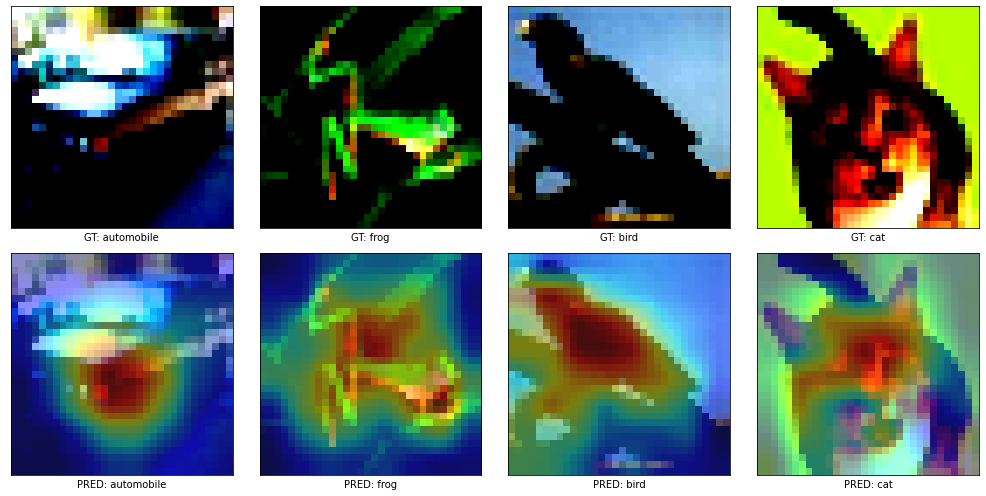

In [45]:
label = ['airplain', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship' ,'truck']
random = np.random.randint(0, 9999, 4)
print(random)
fig, ax = plt.subplots(2, 4, figsize=(14, 7))
for idx, val in enumerate(random):
  new_test = tf.expand_dims(x_test[val], axis=0)
  feature, pred = cam_model(new_test)
  dense_weight = cam_model.get_layer(index=68).get_weights()[0]
  pred = np.argmax(pred)
  cam = tf.reshape(tf.linalg.matmul(tf.reshape(tf.squeeze(feature), (64, 64)), dense_weight), (8, 8, 10))
  cam = tf.divide(tf.subtract(cam, tf.math.reduce_min(cam)), tf.math.reduce_max(cam))
  cam = tf.image.resize(cam, (32, 32))
  ax[0, idx].imshow(x_test[val])
  ax[0, idx].set_xlabel(f'GT: {label[y_test[val][0]]}')
  ax[0, idx].set_xticks([])
  ax[0, idx].set_yticks([])
  ax[1, idx].imshow(cam[:,:,pred], alpha=.9, cmap='jet')
  ax[1, idx].imshow(x_test[val], alpha=.5)
  ax[1, idx].set_xlabel(f'PRED: {label[pred]}')
  ax[1, idx].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
  fig.tight_layout()